# Nuclei Deconvolution and Compare intensities to ground truth

This notebook shows deconvolution of a simulated image.  The images are similar to the ones generated in the ABRF study [here](https://sites.google.com/view/lmrg-image-analysis-study) 


Question:  Does deconvolution restore intensities closer to ground truth?


## Create a decon conda environment

This environment is the same as the one in the first example.  

    conda create --name decon-napari python=3.9
    conda activate decon-napari
    conda install -c conda-forge jupyterlab
    conda install -c conda-forge pyopencl==2021.2.6 hdbscan numba=0.55.1
    pip install devbio-napari
    
    conda install -c conda-forge fftw
    pip install napari-sdeconv
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft
    pip install stardist
    

Mac-users please also install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users please also install this:

    conda install -c conda-forge ocl-icd-system


## Open test images

1.  Get images from this folder https://www.dropbox.com/sh/v3g5zln64e0uhk7/AABcYksPoawlTBO9ELCyqfPOa?dl=0
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder
3.  Print out the size of the images to verify they loaded propertly.  Note that the ground truth and image are different sizes, that is something we will have to deal with (with a careful resizing operation) before comparing. 

In [3]:
from skimage.io import imread

im_path='D:/images/i2k2022/deconvolution/'
im_name='SIM 1.5 NA.tif'
truth_name='phantom.tif'
psf_name='PSF 1.5 NA.tif'

im=imread(im_path+im_name)
truth=imread(im_path+truth_name)
im=im.astype('float32')
print(im.shape, truth.shape)
psf=imread(im_path+psf_name)
psf=psf.astype('float32')

(119, 202, 202) (119, 202, 202)


## Show image, truth and PSF

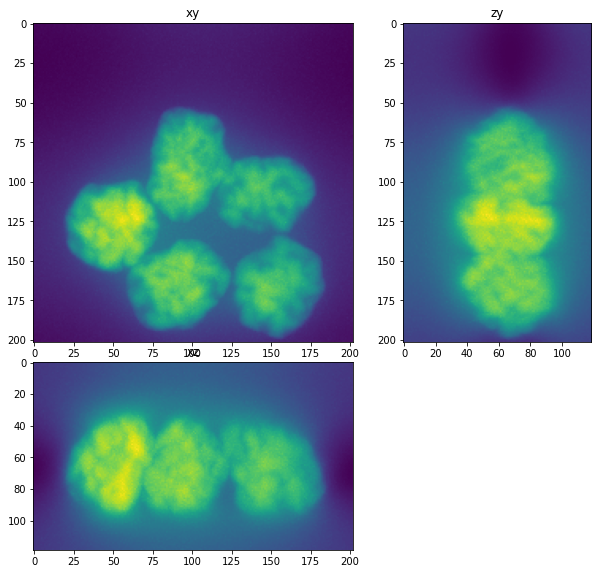

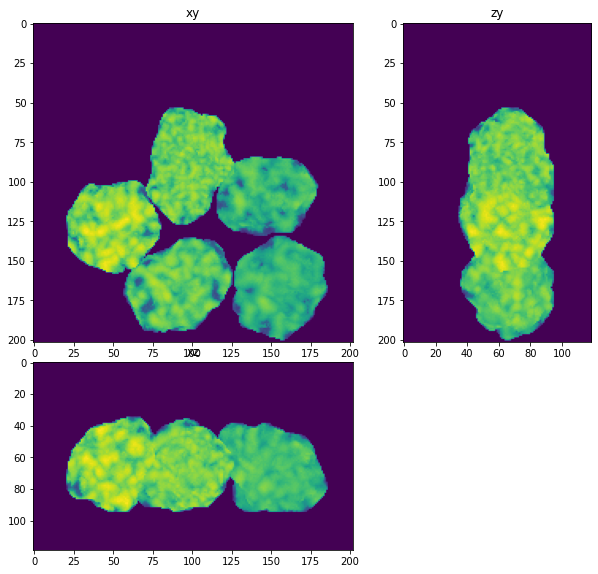

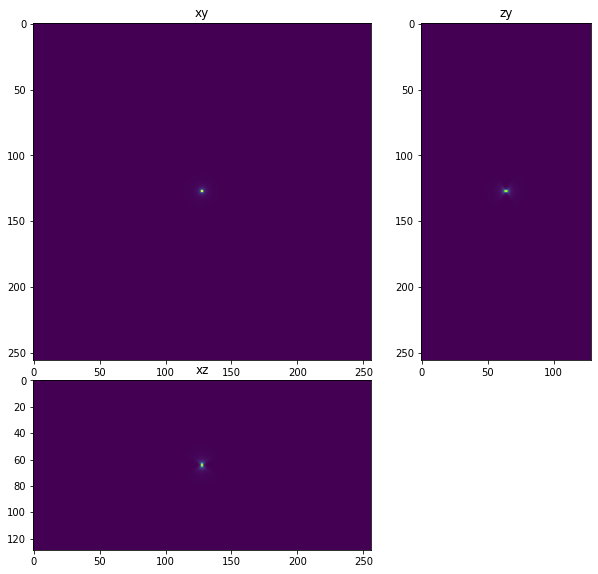

In [5]:
from tnia.plotting.projections import show_xyz_max

fig=show_xyz_max(im)
fig=show_xyz_max(truth)
fig=show_xyz_max(psf)

## Import Deconvolotion and make a 'deconvolver'



In [8]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc
    print('clij2fft non-circulant rl imported')
    regularization_factor=0.0002
    def deconvolver(img, psf, iterations):
        return richardson_lucy_nc(img, psf, iterations, regularization_factor)
    
except ImportError:
    print('clij2fft non-circulant rl not imported')
    try:
        import RedLionfishDeconv as rl
        print('redlionfish rl imported')
        def deconvolver(img, psf, iterations):
            return rl.doRLDeconvolutionFromNpArrays(im, psf, niter=100, method='gpu', resAsUint8=False )
    except ImportError:
        print('redlionfish rl not imported')


clij2fft non-circulant rl imported


get lib


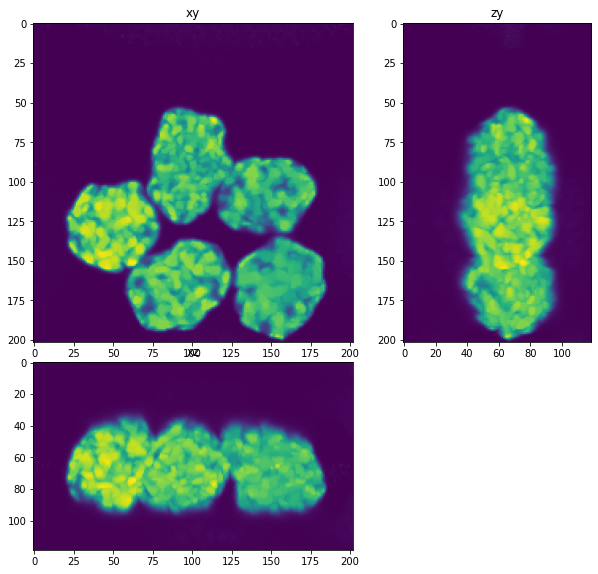

In [22]:
im_decon_200 = deconvolver(im, psf, 200)
im_decon_500 = deconvolver(im, psf, 500)
#im_decon_2000 = deconvolver(im, psf, 2000)

fig = show_xyz_max(im_decon_500)

## Compare to Ground Truth


In [23]:
import numpy as np

def MSE(a,b):
    return np.square(np.subtract(a,b)).mean()

def RMSE(a,b):
    return np.sqrt(MSE(a,b))

print('RMSE image and ground truth',RMSE(truth, im))
print('RMSE deconvolution 200 iterations and ground truth',RMSE(truth, im_decon_200))
print('RMSE deconvolution 500 iterations and ground truth',RMSE(truth, im_decon_500))
print('RMSE deconvolution 2000 iterations and ground truth',RMSE(truth, im_decon_2000))


RMSE image and ground truth 7267.49
RMSE deconvolution 200 iterations and ground truth 3073.1455
RMSE deconvolution 500 iterations and ground truth 2474.483
RMSE deconvolution 2000 iterations and ground truth 2010.1144


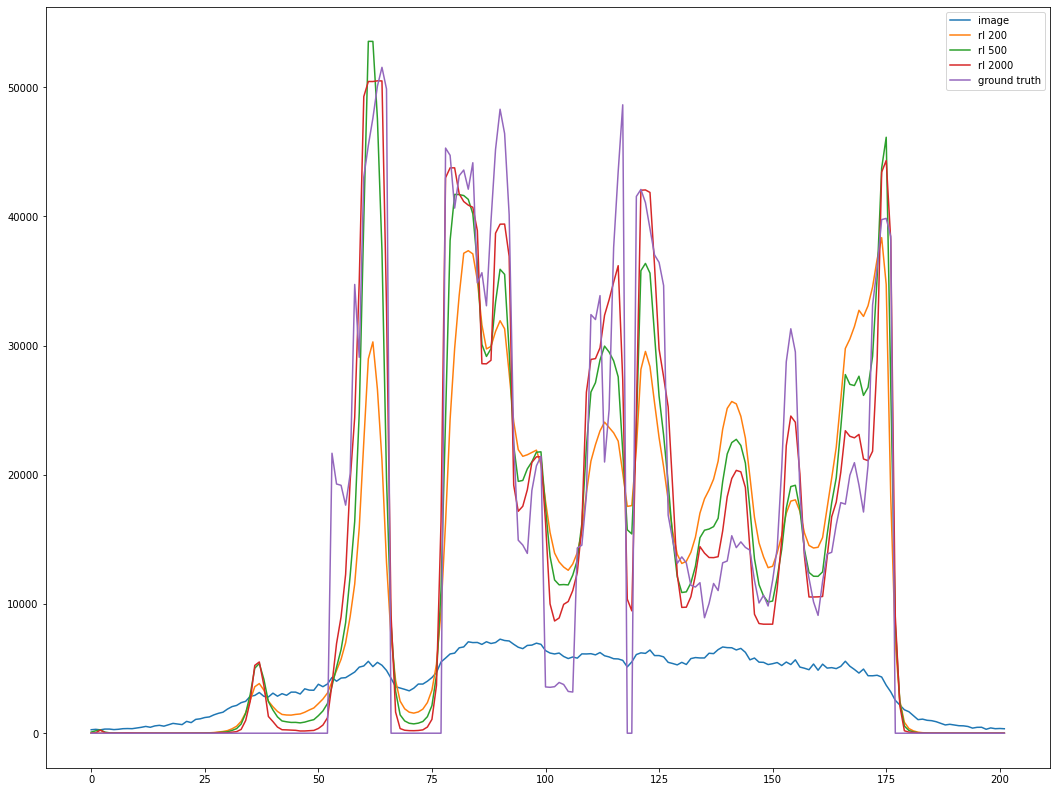

In [24]:
import matplotlib.pyplot as plt
s=im.shape

fig, ax = plt.subplots(figsize=(18,14))

line=im[int(s[0]/2),int(s[1]/2),:]
ax.plot(line, label = 'image')

line2=im_decon_200[int(s[0]/2),int(s[1]/2),:]
ax.plot(line2, label='rl 200')

line3=im_decon_500[int(s[0]/2),int(s[1]/2),:]
ax.plot(line3, label='rl 500')

line3=im_decon_2000[int(s[0]/2),int(s[1]/2),:]
ax.plot(line3, label='rl 2000')

line4=truth[int(s[0]/2),int(s[1]/2),:]
ax.plot(line4, label='ground truth')
ax.legend()

## Visualize in Napari

In [25]:
import napari
viewer=napari.Viewer()

viewer.add_image(im)
viewer.add_image(im_decon_200)
viewer.add_image(im_decon_500)
viewer.add_image(im_decon_2000)
viewer.add_image(truth)


C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\site-packages\jupyter_client\threaded.py", line 122, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "C:\Users\bnort\miniconda3\envs\decon-napari\lib\asyncio\base_events.py", line 623, in ru

<Image layer 'truth' at 0x1c996069f10>